# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8096
Epoch 1/200, Iteration 2/12, Loss: 0.5289
Epoch 1/200, Iteration 3/12, Loss: 0.5600
Epoch 1/200, Iteration 4/12, Loss: 0.5899
Epoch 1/200, Iteration 5/12, Loss: 0.3910
Epoch 1/200, Iteration 6/12, Loss: 0.4012
Epoch 1/200, Iteration 7/12, Loss: 0.4550
Epoch 1/200, Iteration 8/12, Loss: 0.3522
Epoch 1/200, Iteration 9/12, Loss: 0.2890
Epoch 1/200, Iteration 10/12, Loss: 0.2504
Epoch 1/200, Iteration 11/12, Loss: 0.2192
Epoch 1/200, Iteration 12/12, Loss: 0.2805
Epoch 1/200, Iteration 13/12, Loss: 0.2771
Train Error: 
 Accuracy: 49.38%, Avg loss: 0.220904, MRE: 0.145023, MAE: 0.030518 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.197950, MRE: 0.132849, MAE: 0.027533 

Epoch 2/200, Iteration 1/12, Loss: 0.2148
Epoch 2/200, Iteration 2/12, Loss: 0.2136
Epoch 2/200, Iteration 3/12, Loss: 0.1927
Epoch 2/200, Iteration 4/12, Loss: 0.2280
Epoch 2/200, Iteration 5/12, Loss: 0.1801
Epoch 2/200, Iteration 6/12, Loss: 0.1820
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.062817, MRE: 0.041927, MAE: 0.008756 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.064408, MRE: 0.038997, MAE: 0.008860 

Epoch 13/200, Iteration 1/12, Loss: 0.0617
Epoch 13/200, Iteration 2/12, Loss: 0.0526
Epoch 13/200, Iteration 3/12, Loss: 0.0681
Epoch 13/200, Iteration 4/12, Loss: 0.0569
Epoch 13/200, Iteration 5/12, Loss: 0.0531
Epoch 13/200, Iteration 6/12, Loss: 0.0412
Epoch 13/200, Iteration 7/12, Loss: 0.0595
Epoch 13/200, Iteration 8/12, Loss: 0.0430
Epoch 13/200, Iteration 9/12, Loss: 0.0546
Epoch 13/200, Iteration 10/12, Loss: 0.0705
Epoch 13/200, Iteration 11/12, Loss: 0.0399
Epoch 13/200, Iteration 12/12, Loss: 0.0630
Epoch 13/200, Iteration 13/12, Loss: 0.0709
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.059952, MRE: 0.065352, MAE: 0.006975 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.052508, MRE: 0.046191, MAE: 0.006260 

Epoch 14/200, Iteration 1/12, Loss: 0.0524
Epoch 14/200, Iteration 2/12, Loss: 0.0573
Epoch 14/200, Itera

Train Error: 
 Accuracy: 97.38%, Avg loss: 0.056498, MRE: 0.042695, MAE: 0.007291 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.055103, MRE: 0.037381, MAE: 0.007346 

Epoch 25/200, Iteration 1/12, Loss: 0.0531
Epoch 25/200, Iteration 2/12, Loss: 0.0577
Epoch 25/200, Iteration 3/12, Loss: 0.0737
Epoch 25/200, Iteration 4/12, Loss: 0.0691
Epoch 25/200, Iteration 5/12, Loss: 0.0569
Epoch 25/200, Iteration 6/12, Loss: 0.0354
Epoch 25/200, Iteration 7/12, Loss: 0.0537
Epoch 25/200, Iteration 8/12, Loss: 0.0530
Epoch 25/200, Iteration 9/12, Loss: 0.0621
Epoch 25/200, Iteration 10/12, Loss: 0.0483
Epoch 25/200, Iteration 11/12, Loss: 0.0500
Epoch 25/200, Iteration 12/12, Loss: 0.0435
Epoch 25/200, Iteration 13/12, Loss: 0.0505
Train Error: 
 Accuracy: 87.75%, Avg loss: 0.049667, MRE: 0.050018, MAE: 0.005878 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.051522, MRE: 0.044876, MAE: 0.006122 

Epoch 26/200, Iteration 1/12, Loss: 0.0462
Epoch 26/200, Iteration 2/12, Loss: 0.0507
Epoch 26/200, Itera

Epoch 36/200, Iteration 2/12, Loss: 0.0388
Epoch 36/200, Iteration 3/12, Loss: 0.0450
Epoch 36/200, Iteration 4/12, Loss: 0.0284
Epoch 36/200, Iteration 5/12, Loss: 0.0416
Epoch 36/200, Iteration 6/12, Loss: 0.0392
Epoch 36/200, Iteration 7/12, Loss: 0.0315
Epoch 36/200, Iteration 8/12, Loss: 0.0227
Epoch 36/200, Iteration 9/12, Loss: 0.0356
Epoch 36/200, Iteration 10/12, Loss: 0.0396
Epoch 36/200, Iteration 11/12, Loss: 0.0361
Epoch 36/200, Iteration 12/12, Loss: 0.0474
Epoch 36/200, Iteration 13/12, Loss: 0.0444
Train Error: 
 Accuracy: 88.88%, Avg loss: 0.048570, MRE: 0.042046, MAE: 0.006167 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.043690, MRE: 0.036579, MAE: 0.005423 

Epoch 37/200, Iteration 1/12, Loss: 0.0438
Epoch 37/200, Iteration 2/12, Loss: 0.0402
Epoch 37/200, Iteration 3/12, Loss: 0.0393
Epoch 37/200, Iteration 4/12, Loss: 0.0793
Epoch 37/200, Iteration 5/12, Loss: 0.0506
Epoch 37/200, Iteration 6/12, Loss: 0.0399
Epoch 37/200, Iteration 7/12, Loss: 0.0514
Epoch 37/200,

Epoch 47/200, Iteration 7/12, Loss: 0.0173
Epoch 47/200, Iteration 8/12, Loss: 0.0132
Epoch 47/200, Iteration 9/12, Loss: 0.0183
Epoch 47/200, Iteration 10/12, Loss: 0.0129
Epoch 47/200, Iteration 11/12, Loss: 0.0133
Epoch 47/200, Iteration 12/12, Loss: 0.0168
Epoch 47/200, Iteration 13/12, Loss: 0.0161
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.015869, MRE: 0.014348, MAE: 0.002034 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.019048, MRE: 0.012258, MAE: 0.002513 

Epoch 48/200, Iteration 1/12, Loss: 0.0162
Epoch 48/200, Iteration 2/12, Loss: 0.0168
Epoch 48/200, Iteration 3/12, Loss: 0.0156
Epoch 48/200, Iteration 4/12, Loss: 0.0154
Epoch 48/200, Iteration 5/12, Loss: 0.0164
Epoch 48/200, Iteration 6/12, Loss: 0.0170
Epoch 48/200, Iteration 7/12, Loss: 0.0141
Epoch 48/200, Iteration 8/12, Loss: 0.0171
Epoch 48/200, Iteration 9/12, Loss: 0.0139
Epoch 48/200, Iteration 10/12, Loss: 0.0127
Epoch 48/200, Iteration 11/12, Loss: 0.0137
Epoch 48/200, Iteration 12/12, Loss: 0.0147
Epoch 48/2

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011933, MRE: 0.008377, MAE: 0.001591 

Epoch 59/200, Iteration 1/12, Loss: 0.0082
Epoch 59/200, Iteration 2/12, Loss: 0.0083
Epoch 59/200, Iteration 3/12, Loss: 0.0101
Epoch 59/200, Iteration 4/12, Loss: 0.0098
Epoch 59/200, Iteration 5/12, Loss: 0.0098
Epoch 59/200, Iteration 6/12, Loss: 0.0075
Epoch 59/200, Iteration 7/12, Loss: 0.0128
Epoch 59/200, Iteration 8/12, Loss: 0.0109
Epoch 59/200, Iteration 9/12, Loss: 0.0094
Epoch 59/200, Iteration 10/12, Loss: 0.0096
Epoch 59/200, Iteration 11/12, Loss: 0.0096
Epoch 59/200, Iteration 12/12, Loss: 0.0108
Epoch 59/200, Iteration 13/12, Loss: 0.0119
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008934, MRE: 0.009950, MAE: 0.001166 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011388, MRE: 0.008428, MAE: 0.001482 

Epoch 60/200, Iteration 1/12, Loss: 0.0087
Epoch 60/200, Iteration 2/12, Loss: 0.0095
Epoch 60/200, Iteration 3/12, Loss: 0.0097
Epoch 60/200, Iteration 4/12, Loss: 0.0114
Epoch 60/200, I

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008978, MRE: 0.010046, MAE: 0.001157 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010951, MRE: 0.007713, MAE: 0.001422 

Epoch 71/200, Iteration 1/12, Loss: 0.0077
Epoch 71/200, Iteration 2/12, Loss: 0.0084
Epoch 71/200, Iteration 3/12, Loss: 0.0093
Epoch 71/200, Iteration 4/12, Loss: 0.0116
Epoch 71/200, Iteration 5/12, Loss: 0.0075
Epoch 71/200, Iteration 6/12, Loss: 0.0104
Epoch 71/200, Iteration 7/12, Loss: 0.0073
Epoch 71/200, Iteration 8/12, Loss: 0.0085
Epoch 71/200, Iteration 9/12, Loss: 0.0083
Epoch 71/200, Iteration 10/12, Loss: 0.0083
Epoch 71/200, Iteration 11/12, Loss: 0.0093
Epoch 71/200, Iteration 12/12, Loss: 0.0090
Epoch 71/200, Iteration 13/12, Loss: 0.0085
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008089, MRE: 0.008589, MAE: 0.001086 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010889, MRE: 0.007272, MAE: 0.001479 

Epoch 72/200, Iteration 1/12, Loss: 0.0078
Epoch 72/200, Iteration 2/12, Loss: 0.0090
Epoch 72/200, Ite

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007728, MRE: 0.007589, MAE: 0.000968 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010899, MRE: 0.006992, MAE: 0.001393 

Epoch 83/200, Iteration 1/12, Loss: 0.0071
Epoch 83/200, Iteration 2/12, Loss: 0.0083
Epoch 83/200, Iteration 3/12, Loss: 0.0097
Epoch 83/200, Iteration 4/12, Loss: 0.0083
Epoch 83/200, Iteration 5/12, Loss: 0.0073
Epoch 83/200, Iteration 6/12, Loss: 0.0066
Epoch 83/200, Iteration 7/12, Loss: 0.0096
Epoch 83/200, Iteration 8/12, Loss: 0.0079
Epoch 83/200, Iteration 9/12, Loss: 0.0068
Epoch 83/200, Iteration 10/12, Loss: 0.0070
Epoch 83/200, Iteration 11/12, Loss: 0.0067
Epoch 83/200, Iteration 12/12, Loss: 0.0083
Epoch 83/200, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007148, MRE: 0.007743, MAE: 0.000903 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009676, MRE: 0.006767, MAE: 0.001246 

Epoch 84/200, Iteration 1/12, Loss: 0.0067
Epoch 84/200, Iteration 2/12, Loss: 0.0073
Epoch 84/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007319, MRE: 0.007050, MAE: 0.001011 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009598, MRE: 0.006371, MAE: 0.001291 

Epoch 95/200, Iteration 1/12, Loss: 0.0078
Epoch 95/200, Iteration 2/12, Loss: 0.0092
Epoch 95/200, Iteration 3/12, Loss: 0.0075
Epoch 95/200, Iteration 4/12, Loss: 0.0067
Epoch 95/200, Iteration 5/12, Loss: 0.0077
Epoch 95/200, Iteration 6/12, Loss: 0.0066
Epoch 95/200, Iteration 7/12, Loss: 0.0061
Epoch 95/200, Iteration 8/12, Loss: 0.0058
Epoch 95/200, Iteration 9/12, Loss: 0.0066
Epoch 95/200, Iteration 10/12, Loss: 0.0077
Epoch 95/200, Iteration 11/12, Loss: 0.0065
Epoch 95/200, Iteration 12/12, Loss: 0.0063
Epoch 95/200, Iteration 13/12, Loss: 0.0068
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.006973, MRE: 0.007087, MAE: 0.000909 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009614, MRE: 0.006215, MAE: 0.001272 

Epoch 96/200, Iteration 1/12, Loss: 0.0071
Epoch 96/200, Iteration 2/12, Loss: 0.0059
Epoch 96/200, Ite

Epoch 106/200, Iteration 11/12, Loss: 0.0067
Epoch 106/200, Iteration 12/12, Loss: 0.0042
Epoch 106/200, Iteration 13/12, Loss: 0.0034
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004322, MRE: 0.005714, MAE: 0.000578 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008552, MRE: 0.005584, MAE: 0.001148 

Epoch 107/200, Iteration 1/12, Loss: 0.0037
Epoch 107/200, Iteration 2/12, Loss: 0.0057
Epoch 107/200, Iteration 3/12, Loss: 0.0035
Epoch 107/200, Iteration 4/12, Loss: 0.0051
Epoch 107/200, Iteration 5/12, Loss: 0.0042
Epoch 107/200, Iteration 6/12, Loss: 0.0041
Epoch 107/200, Iteration 7/12, Loss: 0.0043
Epoch 107/200, Iteration 8/12, Loss: 0.0046
Epoch 107/200, Iteration 9/12, Loss: 0.0045
Epoch 107/200, Iteration 10/12, Loss: 0.0042
Epoch 107/200, Iteration 11/12, Loss: 0.0049
Epoch 107/200, Iteration 12/12, Loss: 0.0047
Epoch 107/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004307, MRE: 0.005681, MAE: 0.000574 

Test Error: 
 Accuracy: 100.0%, Avg lo

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004111, MRE: 0.005798, MAE: 0.000550 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008610, MRE: 0.005578, MAE: 0.001153 

Epoch 118/200, Iteration 1/12, Loss: 0.0044
Epoch 118/200, Iteration 2/12, Loss: 0.0035
Epoch 118/200, Iteration 3/12, Loss: 0.0043
Epoch 118/200, Iteration 4/12, Loss: 0.0044
Epoch 118/200, Iteration 5/12, Loss: 0.0033
Epoch 118/200, Iteration 6/12, Loss: 0.0045
Epoch 118/200, Iteration 7/12, Loss: 0.0038
Epoch 118/200, Iteration 8/12, Loss: 0.0045
Epoch 118/200, Iteration 9/12, Loss: 0.0038
Epoch 118/200, Iteration 10/12, Loss: 0.0052
Epoch 118/200, Iteration 11/12, Loss: 0.0036
Epoch 118/200, Iteration 12/12, Loss: 0.0054
Epoch 118/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004330, MRE: 0.005752, MAE: 0.000577 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008490, MRE: 0.005539, MAE: 0.001137 

Epoch 119/200, Iteration 1/12, Loss: 0.0045
Epoch 119/200, Iteration 2/12, Loss: 0.0036
Ep

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003929, MRE: 0.005390, MAE: 0.000527 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008569, MRE: 0.005503, MAE: 0.001150 

Epoch 130/200, Iteration 1/12, Loss: 0.0036
Epoch 130/200, Iteration 2/12, Loss: 0.0035
Epoch 130/200, Iteration 3/12, Loss: 0.0046
Epoch 130/200, Iteration 4/12, Loss: 0.0032
Epoch 130/200, Iteration 5/12, Loss: 0.0049
Epoch 130/200, Iteration 6/12, Loss: 0.0041
Epoch 130/200, Iteration 7/12, Loss: 0.0035
Epoch 130/200, Iteration 8/12, Loss: 0.0037
Epoch 130/200, Iteration 9/12, Loss: 0.0035
Epoch 130/200, Iteration 10/12, Loss: 0.0044
Epoch 130/200, Iteration 11/12, Loss: 0.0038
Epoch 130/200, Iteration 12/12, Loss: 0.0036
Epoch 130/200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003989, MRE: 0.005439, MAE: 0.000537 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008504, MRE: 0.005540, MAE: 0.001138 

Epoch 131/200, Iteration 1/12, Loss: 0.0038
Epoch 131/200, Iteration 2/12, Loss: 0.0034
Ep

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008520, MRE: 0.005436, MAE: 0.001136 

Epoch 141/200, Iteration 1/12, Loss: 0.0037
Epoch 141/200, Iteration 2/12, Loss: 0.0038
Epoch 141/200, Iteration 3/12, Loss: 0.0050
Epoch 141/200, Iteration 4/12, Loss: 0.0037
Epoch 141/200, Iteration 5/12, Loss: 0.0038
Epoch 141/200, Iteration 6/12, Loss: 0.0041
Epoch 141/200, Iteration 7/12, Loss: 0.0046
Epoch 141/200, Iteration 8/12, Loss: 0.0034
Epoch 141/200, Iteration 9/12, Loss: 0.0037
Epoch 141/200, Iteration 10/12, Loss: 0.0032
Epoch 141/200, Iteration 11/12, Loss: 0.0040
Epoch 141/200, Iteration 12/12, Loss: 0.0044
Epoch 141/200, Iteration 13/12, Loss: 0.0047
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004147, MRE: 0.005335, MAE: 0.000541 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008587, MRE: 0.005754, MAE: 0.001149 

Epoch 142/200, Iteration 1/12, Loss: 0.0048
Epoch 142/200, Iteration 2/12, Loss: 0.0046
Epoch 142/200, Iteration 3/12, Loss: 0.0038
Epoch 142/200, Iteration 4/12, Loss: 0.003

Epoch 152/200, Iteration 7/12, Loss: 0.0037
Epoch 152/200, Iteration 8/12, Loss: 0.0051
Epoch 152/200, Iteration 9/12, Loss: 0.0047
Epoch 152/200, Iteration 10/12, Loss: 0.0039
Epoch 152/200, Iteration 11/12, Loss: 0.0039
Epoch 152/200, Iteration 12/12, Loss: 0.0056
Epoch 152/200, Iteration 13/12, Loss: 0.0036
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004090, MRE: 0.005524, MAE: 0.000556 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008780, MRE: 0.005528, MAE: 0.001183 

Epoch 153/200, Iteration 1/12, Loss: 0.0038
Epoch 153/200, Iteration 2/12, Loss: 0.0042
Epoch 153/200, Iteration 3/12, Loss: 0.0049
Epoch 153/200, Iteration 4/12, Loss: 0.0047
Epoch 153/200, Iteration 5/12, Loss: 0.0042
Epoch 153/200, Iteration 6/12, Loss: 0.0032
Epoch 153/200, Iteration 7/12, Loss: 0.0036
Epoch 153/200, Iteration 8/12, Loss: 0.0041
Epoch 153/200, Iteration 9/12, Loss: 0.0035
Epoch 153/200, Iteration 10/12, Loss: 0.0036
Epoch 153/200, Iteration 11/12, Loss: 0.0040
Epoch 153/200, Iteration 12/12, Los

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008508, MRE: 0.005484, MAE: 0.001127 

Epoch 164/200, Iteration 1/12, Loss: 0.0033
Epoch 164/200, Iteration 2/12, Loss: 0.0044
Epoch 164/200, Iteration 3/12, Loss: 0.0035
Epoch 164/200, Iteration 4/12, Loss: 0.0041
Epoch 164/200, Iteration 5/12, Loss: 0.0034
Epoch 164/200, Iteration 6/12, Loss: 0.0038
Epoch 164/200, Iteration 7/12, Loss: 0.0036
Epoch 164/200, Iteration 8/12, Loss: 0.0039
Epoch 164/200, Iteration 9/12, Loss: 0.0045
Epoch 164/200, Iteration 10/12, Loss: 0.0039
Epoch 164/200, Iteration 11/12, Loss: 0.0038
Epoch 164/200, Iteration 12/12, Loss: 0.0044
Epoch 164/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003715, MRE: 0.005090, MAE: 0.000504 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008464, MRE: 0.005424, MAE: 0.001134 

Epoch 165/200, Iteration 1/12, Loss: 0.0030
Epoch 165/200, Iteration 2/12, Loss: 0.0032
Epoch 165/200, Iteration 3/12, Loss: 0.0044
Epoch 165/200, Iteration 4/12, Loss: 0.005

Epoch 175/200, Iteration 3/12, Loss: 0.0030
Epoch 175/200, Iteration 4/12, Loss: 0.0033
Epoch 175/200, Iteration 5/12, Loss: 0.0039
Epoch 175/200, Iteration 6/12, Loss: 0.0032
Epoch 175/200, Iteration 7/12, Loss: 0.0040
Epoch 175/200, Iteration 8/12, Loss: 0.0041
Epoch 175/200, Iteration 9/12, Loss: 0.0035
Epoch 175/200, Iteration 10/12, Loss: 0.0041
Epoch 175/200, Iteration 11/12, Loss: 0.0039
Epoch 175/200, Iteration 12/12, Loss: 0.0034
Epoch 175/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003839, MRE: 0.005101, MAE: 0.000512 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008612, MRE: 0.005488, MAE: 0.001151 

Epoch 176/200, Iteration 1/12, Loss: 0.0038
Epoch 176/200, Iteration 2/12, Loss: 0.0035
Epoch 176/200, Iteration 3/12, Loss: 0.0034
Epoch 176/200, Iteration 4/12, Loss: 0.0038
Epoch 176/200, Iteration 5/12, Loss: 0.0039
Epoch 176/200, Iteration 6/12, Loss: 0.0037
Epoch 176/200, Iteration 7/12, Loss: 0.0030
Epoch 176/200, Iteration 8/12, Loss: 

Epoch 186/200, Iteration 6/12, Loss: 0.0038
Epoch 186/200, Iteration 7/12, Loss: 0.0032
Epoch 186/200, Iteration 8/12, Loss: 0.0039
Epoch 186/200, Iteration 9/12, Loss: 0.0050
Epoch 186/200, Iteration 10/12, Loss: 0.0035
Epoch 186/200, Iteration 11/12, Loss: 0.0047
Epoch 186/200, Iteration 12/12, Loss: 0.0042
Epoch 186/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003797, MRE: 0.005119, MAE: 0.000514 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008597, MRE: 0.005617, MAE: 0.001153 

Epoch 187/200, Iteration 1/12, Loss: 0.0036
Epoch 187/200, Iteration 2/12, Loss: 0.0038
Epoch 187/200, Iteration 3/12, Loss: 0.0037
Epoch 187/200, Iteration 4/12, Loss: 0.0042
Epoch 187/200, Iteration 5/12, Loss: 0.0036
Epoch 187/200, Iteration 6/12, Loss: 0.0053
Epoch 187/200, Iteration 7/12, Loss: 0.0035
Epoch 187/200, Iteration 8/12, Loss: 0.0038
Epoch 187/200, Iteration 9/12, Loss: 0.0041
Epoch 187/200, Iteration 10/12, Loss: 0.0032
Epoch 187/200, Iteration 11/12, Loss

Epoch 198/200, Iteration 10/12, Loss: 0.0049
Epoch 198/200, Iteration 11/12, Loss: 0.0040
Epoch 198/200, Iteration 12/12, Loss: 0.0048
Epoch 198/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003354, MRE: 0.004851, MAE: 0.000453 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008506, MRE: 0.005432, MAE: 0.001136 

Epoch 199/200, Iteration 1/12, Loss: 0.0037
Epoch 199/200, Iteration 2/12, Loss: 0.0030
Epoch 199/200, Iteration 3/12, Loss: 0.0032
Epoch 199/200, Iteration 4/12, Loss: 0.0029
Epoch 199/200, Iteration 5/12, Loss: 0.0039
Epoch 199/200, Iteration 6/12, Loss: 0.0028
Epoch 199/200, Iteration 7/12, Loss: 0.0030
Epoch 199/200, Iteration 8/12, Loss: 0.0033
Epoch 199/200, Iteration 9/12, Loss: 0.0028
Epoch 199/200, Iteration 10/12, Loss: 0.0037
Epoch 199/200, Iteration 11/12, Loss: 0.0038
Epoch 199/200, Iteration 12/12, Loss: 0.0038
Epoch 199/200, Iteration 13/12, Loss: 0.0041
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003416, MRE: 0.007221, MAE: 0.00

#### Plots loss vs Epoch

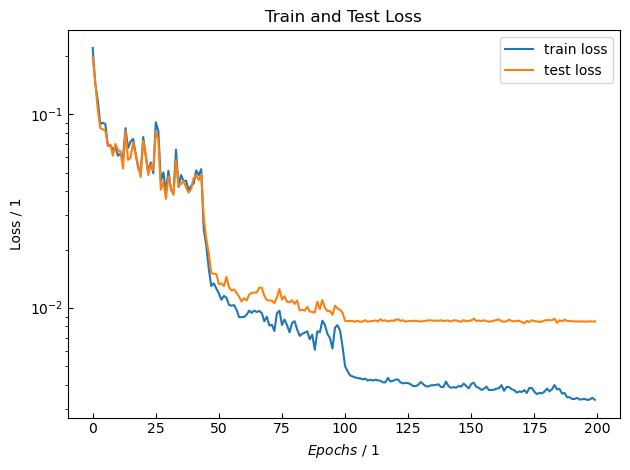

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999698146377229 , R^2(NH3) = 0.9999425433040603
Test Dataset: R^2(H2) = 0.9998830191944394 , R^2(NH3) = 0.9998378714819582
Max Error Training: |x_H2 - x_H2,pred| = 0.010926517681958292 , |x_NH3 - x_NH3,pred| = 0.010549196767771704
Max Error Test: |x_H2 - x_H2,pred| = 0.006773031094772564 , |x_NH3 - x_NH3,pred| = 0.006021250145663487


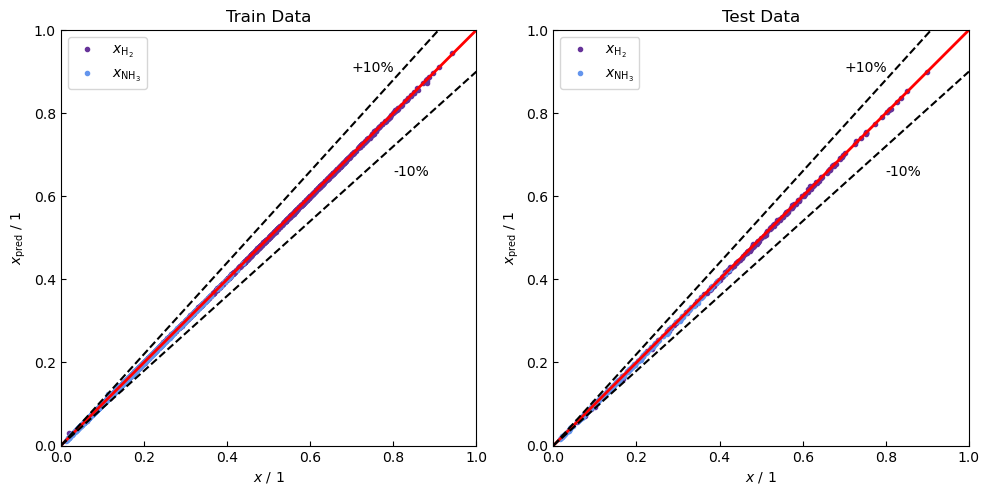

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

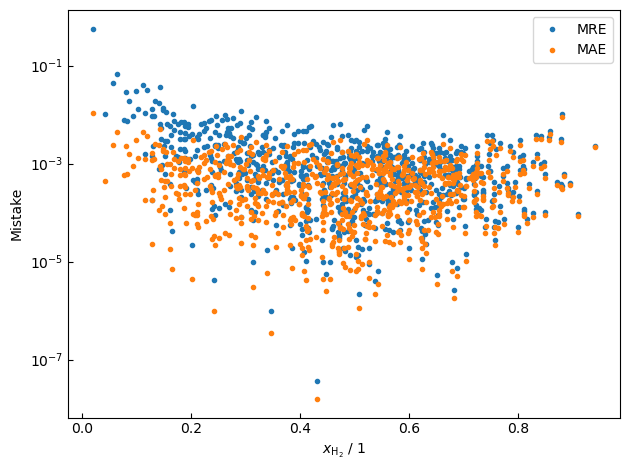

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

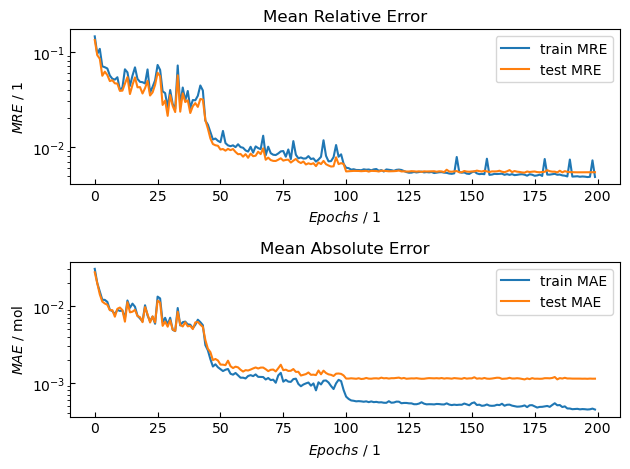

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

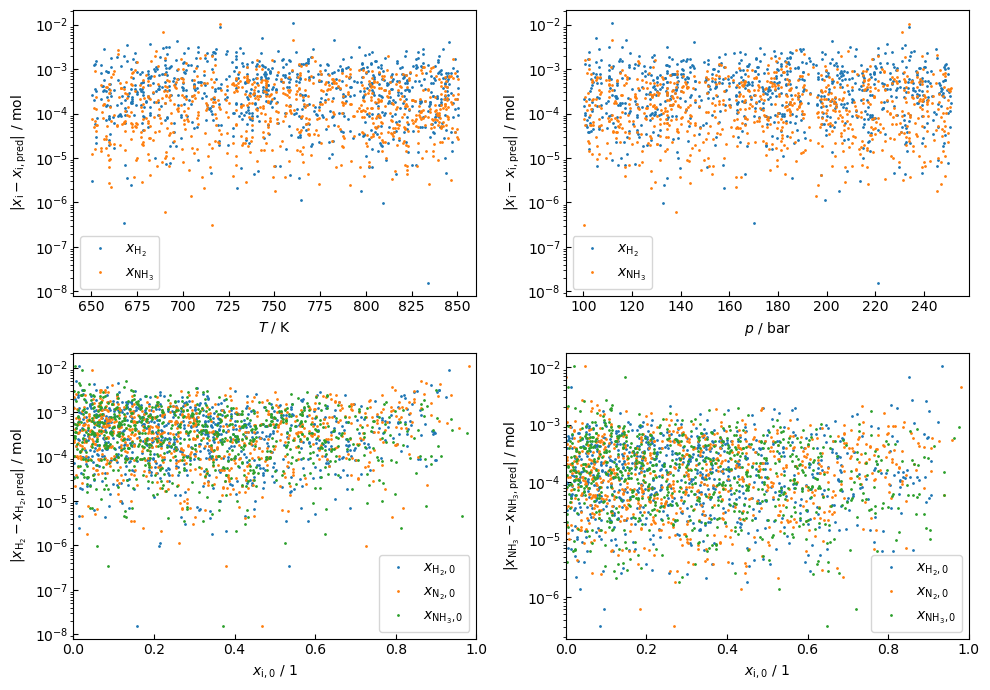

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

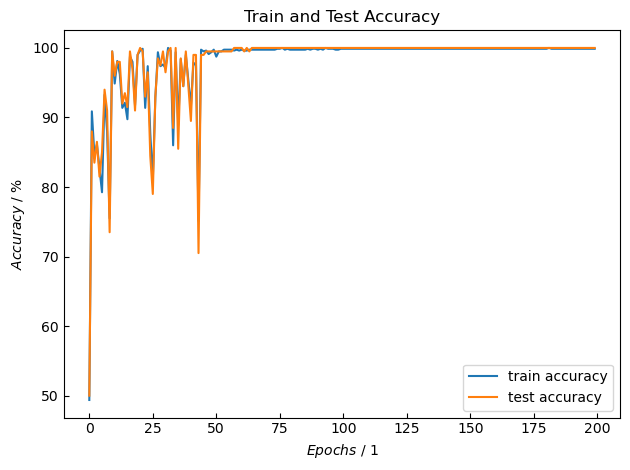

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [-1.3352e-01,  9.9868e-01, -1.2047e+00,  2.2949e+00, -1.1633e+00],
        [ 3.9789e-01,  2.0244e-01,  2.0372e+00, -1.2713e+00, -6.9996e-01],
        [ 9.5866e-01, -2.5968e-01, -1.2127e-01,  1.5521e-01, -3.9622e-02],
        [ 9.7208e-01,  1.7176e+00,  1.4535e+00, -1.1569e+00, -2.4407e-01],
        [-1.0751e+00, -5.4105e-01, -7.6198e-01, -8.0966e-01,  1.5753e+00],
        [ 8.7066e-01,  1.0656e+00, -7.6539e-01, -2.6253e-01,  1.0195e+00],
        [-5.3441e-01,  3.1836e-01,  5.1772e-01, -1.3595e+00,  8.8141e-01],
        [-9.8495e-01,  1.4651e+00,  5.7657e-01, -5.5475e-01,  1.1575e-03],
        [ 1.3538e+00, -2.7704e-01,  4.5743e-01,  3.8985e-01, -8.4736e-01],
        [-1.2213e-01, -1.2368e+00, -8.4085e-02,  1.0809e+00, -1.0223e+00],
        [ 5.9265e-01, -9.3582e-01, -8.4123e-01,  1.6504e+00, -8.6125e-01],
        [-1.6180e+00,  1.4353e+00,  1.9329e+00, -8.9135e-01, -9.8587e-01],
        [-1.1193e+00, -8.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-4.7255e-03, -9.8798e-02,  1.4015e-01, -4.0668e-02,  2.3740e-02],
         [ 2.9851e-01, -1.7575e-01, -2.2862e-01, -1.0246e-01, -1.5912e-01],
         [-1.3767e-01, -1.4897e-01, -1.4352e-01, -2.0503e-01, -2.0858e-01],
         [-1.9168e-01, -1.6654e-02, -4.3621e-02,  2.2660e-01, -2.8537e-01],
         [-5.2148e-01,  2.6071e-01, -1.4108e-01, -3.5560e-01, -4.1531e-02],
         [ 1.5494e-02,  2.3775e-02,  2.3604e-01,  2.5293e-01,  1.4025e-02],
         [ 6.8349e-02,  3.1099e-01, -5.2982e-02,  2.2426e-01, -1.9818e-01],
         [ 2.5038e-01, -1.1641e-02,  4.5072e-02, -3.2301e-01,  1.3998e-02],
         [-4.6152e-01, -4.2550e-02,  3.0055e-02,  2.7243e-01, -8.5938e-02],
         [ 3.8283e-01, -3.9599e-01, -5.4151e-02, -3.0851e-01,  5.5265e-02],
         [-3.5960e-01,  9.6005e-03, -1.4932e-01, -1.1247e-01, -1.6417e-01],
         [ 3.0128e-01, -1.7102e-01, -1.2433e-01,  2.2522e-01,  1.6171e-02],
         [-3.2170e-02, -1.9349e-01,  5.3092e-01, -4.2173e-01,  2.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4099, 0.5787, 0.6249, 0.4405, 0.0149],
        [0.3960, 0.0587, 0.8710, 0.3893, 0.4778]])
tensor([[-0.0551, -0.1036],
        [ 0.2252, -0.1347]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 3.8901e-01, -1.1354e+00,  8.4590e-01, -1.0446e+00,  2.3752e-01],
        [ 4.3804e-02, -7.8794e-01, -7.7118e-02,  1.0980e+00, -1.0465e+00],
        [ 1.5685e+00,  2.5778e-01,  5.0059e-01, -5.6895e-01,  9.0238e-02],
        [ 9.9007e-01,  4.5866e-03,  1.3258e+00, -2.4641e-02, -1.2759e+00],
        [ 1.6201e-01, -1.6405e+00, -8.0775e-01, -1.7207e-01,  9.6858e-01],
        [-1.4937e+00,  1.2425e+00, -5.4250e-02, -7.9974e-01,  8.7063e-01],
        [-5.9056e-01, -1.1820e+00,  5.6155e-01, -7.2274e-02, -4.7722e-01],
        [ 8.8289e-01, -9.3013e-01, -1.8951e-01, -2.5134e-01,  4.4287e-01],
        [ 8.1100e-01, -1.6654e-01,  6.0314e-01, -1.1063e-02, -5.8061e-01],
        [-7.0314e-02, -6.7924e-01, -1.3253e-01,  1.1644e+00, -1.0600e+00],
        [ 1.3623e-01, -2.0137e-02,  9.9547e-01,  5.2604e-03, -9.8231e-01],
        [-7.1468e-01, -1.2815e+00,  2.0716e+00, -9.3383e-01, -1.0786e+00],
        [-1.7006e+00,  5.7091e-01, -9.8697e-01,  1.1048e+00, -1.6058e-01],
        [-9.4457e-01,  1.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()